# Analysis
Created by Ivan Lima on 2020-04-07 20:11:35 

In this notebook we examine gender differences in NSF Ocean Sciences awards between 1987 and 2019. The metrics we use for gender discrepancies are the annual fraction of female PIs and co-PIs in the awards. We track those metrics across: 

1. All NSF-OCE awards.
2. Awards from the top 10 largest NSF programs (in number of awards).
3. Across the top 10 academic organizations (in number of awards).
4. Identified research topics.
5. Award types

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Tue Nov  3 21:23:35 2020


In [2]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 50

## All NSF-OCE awards

In [3]:
# Read NSF-OCE award data
data_types = {'Abstract':'string', 'Title':'string', 'Programs':'string', 'PI':'string',
              'Organization':'string', 'State':'string', 'Instrument':'string', 'co-PIs':'string',
              'program':'string', 'PI_first_name':'string', 'co-PI_first_name':'string',
              'PI_gender':'string', 'co-PI_gender':'string'}
awards = pd.read_csv('results/awards_1985-2020_clean_edited_grouped_gender_topic.csv', index_col=0,
                     parse_dates=[4,5], dtype=data_types)

topic_probs = pd.read_csv('results/topic_probs.csv', index_col=0)
topic_words = pd.read_csv('results/topic_words.csv', index_col=0)

npzfile = np.load('results/NMF_TSNE.npz')
feature_names  = npzfile['feature_names']
nmf_components = npzfile['nmf_components']
topic_names    = npzfile['topic_names']
topic_names_r  = npzfile['topic_names_r']
X_tsne         = npzfile['X_tsne']
npzfile.close()
# awards.info()

# Read geosciences/atmospheric/ocean sciences academic gender workforce data
workforce = pd.read_csv('data/nsf_workforce.csv')#, index_col=0)
workforce['female_frac'] = workforce.female/workforce.total

The figure below shows the number of awards and the amount awarded by NSF Ocean Sciences per year, and a box plot of the amount awarded to individual projects in each year between 1987 and 2019.

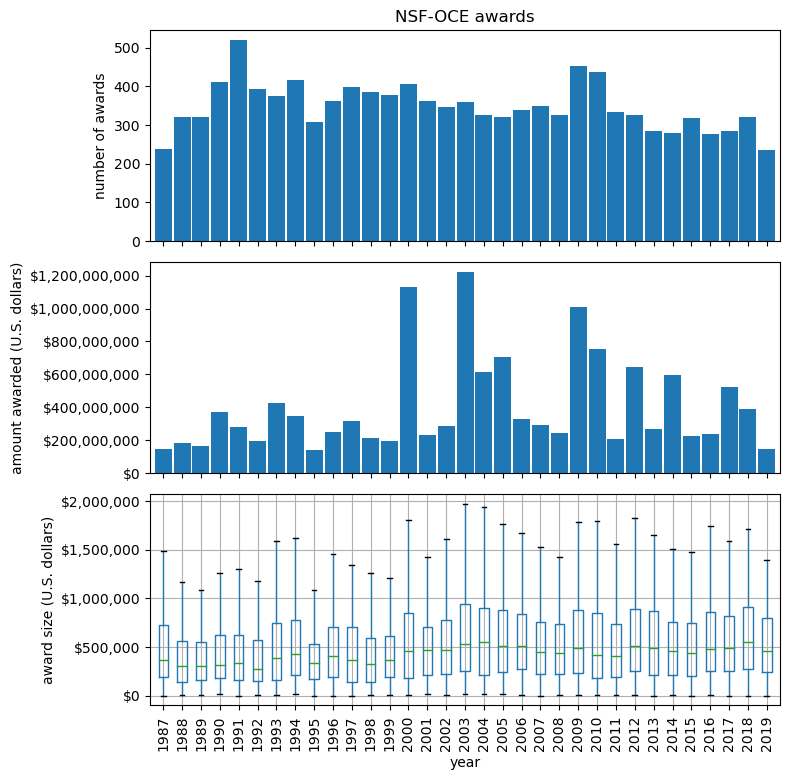

In [4]:
from matplotlib import ticker
def dollar(x, pos):
    return '${:,.0f}'.format(x)
fmt = ticker.FuncFormatter(dollar)

number_per_year = awards.groupby(awards.StartDate.dt.year)['Abstract'].count()
amount_per_year = awards.groupby([awards.StartDate.dt.year])['tot_amount_adjusted'].sum()
awards['year'] = awards.StartDate.dt.year

fig, axs = plt.subplots(3, 1, figsize=(9,9))
_ = number_per_year.plot(kind='bar',ax=axs[0], width=0.9, legend=False)
_ = axs[0].set(title='NSF-OCE awards', ylabel='number of awards', xticklabels='', xlabel='')
_ = amount_per_year.plot(kind='bar',ax=axs[1], width=0.9)
_ = axs[1].yaxis.set_major_formatter(fmt)
_ = axs[1].set(ylabel='amount awarded (U.S. dollars)', xticklabels='', xlabel='')
_ = awards.boxplot('tot_amount_adjusted', by='year', showfliers=False,rot=90, ax=axs[2])
_ = axs[2].yaxis.set_major_formatter(fmt)
_ = axs[2].set(title='', ylabel='award size (U.S. dollars)')
_ = axs[2].set_xlim(0.3, 33.7)
fig.suptitle('')
fig.subplots_adjust(left=0.2, hspace=0.1)

The figure below shows the time series of the annual fraction of female PIs and co-PIs across all awards and the fraction of females in the academic workforce between 1987 and 2019. 
<!-- Solid lines represent a 3-year sliding window average (except for workforce data) and points represent the individual years. -->

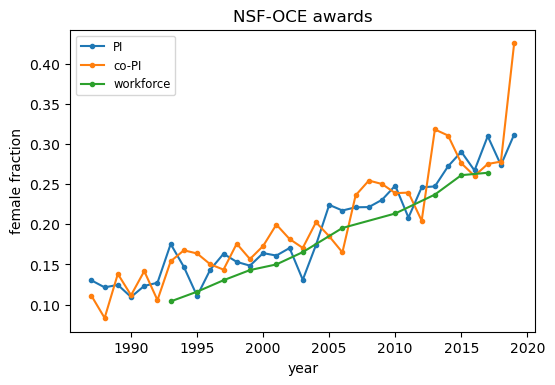

In [5]:
# female & male fraction of PIs
pi_gender = awards.groupby([awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender = pi_gender.divide(pi_gender.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender = pd.DataFrame({'female':awards.groupby(awards.StartDate.dt.year)['co-PI_female_frac'].mean()})
copi_gender['male'] = 1 - copi_gender.female

# female fraction of PIs & co-PIs
female_frac = pd.DataFrame({'PI':pi_gender['female'], 'co-PI':copi_gender['female']})
female_frac.index.rename('year',inplace=True)

fig, ax = plt.subplots()
_ = female_frac.plot(ax=ax, style='.-', legend=False)
# _ = female_frac.plot(ax=ax, style=['C0.','C1.'],legend=False, alpha=0.5)
# _ = female_frac.rolling(3,center=True).mean().plot(ax=ax, legend=False)
_ = workforce.plot(x='year', y='female_frac', ax=ax, style='.-', label='workforce', legend=False)
_ = ax.set(title='NSF-OCE awards', ylabel='female fraction')
lines = ax.get_lines()
_ = ax.legend(lines,['PI','co-PI','workforce'])

The temporal trends seem to be linear

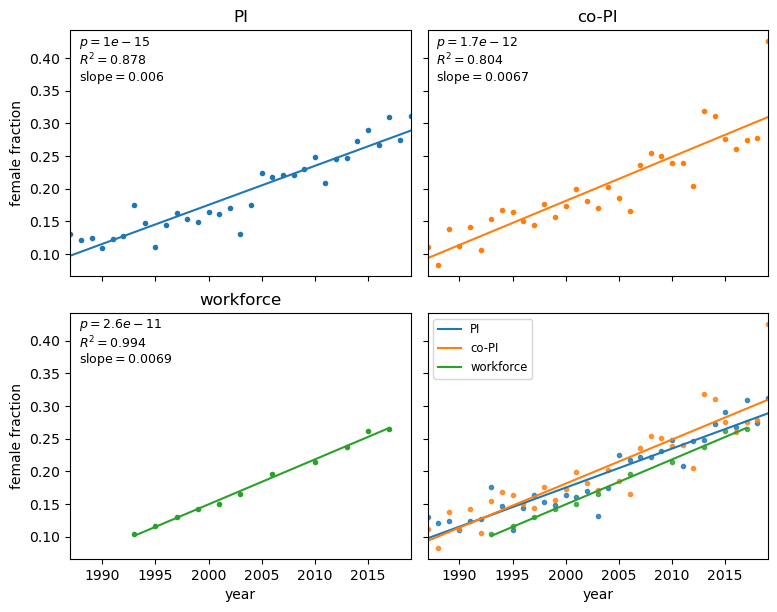

In [6]:
import statsmodels.api as sm
import seaborn as sns

def linreg(x, y):
    X = sm.add_constant(x)
    lreg = sm.OLS(y,X).fit()
    return lreg, X

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 7))
fig.subplots_adjust(wspace=0.05, hspace=0.15)

_ = female_frac.PI.plot(ax=axs[0,0], style='C0.')
_ = axs[0,0].set(title='PI', ylabel='female fraction')

_ = female_frac['co-PI'].plot(ax=axs[0,1], style='C1.')
_ = axs[0,1].set(title='co-PI', ylabel='female fraction')

_ = workforce.plot(x='year', y='female_frac', ax=axs[1,0], style='C2.', legend=False)
_ = axs[1,0].set(title='workforce', ylabel='female fraction')

for ax, x, y, s in zip(axs.ravel(),[female_frac.index, female_frac.index, workforce.year],
                       [female_frac.PI, female_frac['co-PI'], workforce.female_frac],['C0-','C1-','C2-']):
    reg, X = linreg(x, y)
    p, slope, rsquared = reg.pvalues[1], reg.params[1], reg.rsquared
    _ = ax.plot(x, reg.predict(X), s)
    _ = ax.text(0.025,0.95, '$p={:.2g}$'.format(p), transform=ax.transAxes, ha='left',
                va='center', fontsize=9)
    _ = ax.text(0.025,0.88, '$R^2={:.3g}$'.format(rsquared), transform=ax.transAxes, ha='left',
                va='center', fontsize=9)
    _ = ax.text(0.025,0.81, 'slope$={:.2g}$'.format(slope), transform=ax.transAxes, ha='left',
                va='center', fontsize=9)
    
_ = sns.regplot(female_frac.index,female_frac.PI, ax=axs[1,1], marker='.', ci=None, line_kws={'linewidth':1.5})
_ = sns.regplot(female_frac.index,female_frac['co-PI'], ax=axs[1,1], marker='.', ci=None, line_kws={'linewidth':1.5})
_ = sns.regplot(workforce.year,workforce.female_frac, ax=axs[1,1], marker='.', ci=None, line_kws={'linewidth':1.5})
lines = axs[1,1].get_lines()
_ = axs[1,1].legend(lines,['PI','co-PI','workforce'], loc='upper left')

We use a multivariate linear regression of *female fraction* on *time* (year), *category* (PI or co-PI) plus an interaction term (*time* $\times$ *category*) to test whether the temporal trend (slope) and the mean female fraction (intercept) are different between PIs and co-PIs. The table below shows the results from the multivariate linear regression. The large $p$ values for *category* and the interaction term indicate that the differences in intercept and regression slope between PIs and co-PIs are not statistically significant.

In [7]:
import statsmodels.formula.api as smf

df_pi = pd.DataFrame({'fem_frac':female_frac['PI'], 'category':'PI'})
df_copi = pd.DataFrame({'fem_frac':female_frac['co-PI'], 'category':'co-PI'})
df  = pd.concat([df_pi,df_copi]).reset_index()
lreg = smf.ols(formula='fem_frac ~ year + category + year:category', data=df)
res = lreg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fem_frac   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     105.1
Date:                Tue, 03 Nov 2020   Prob (F-statistic):           2.86e-24
Time:                        21:23:39   Log-Likelihood:                 144.76
No. Observations:                  66   AIC:                            -281.5
Df Residuals:                      62   BIC:                            -272.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -11.7820      1.020    -11.555      0.000     -13.820      -9.744
category[T.co-PI]         -1.5340      1.442     -1.064      0.292      -4.417       1.349
year                       0.0060      0.001     11.744      0.000       0.005       0.007
year:category[T.co-PI]     0.0008      0.001      1.070      0.289      -0.001       0.002
==============================================================================
Omnibus:                       20.244   Durbin-Watson:                   1.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.334
Skew:                           0.879   Prob(JB):                     1.94e-11
Kurtosis:                       6.854   Cond. No.                     1.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression slopes for the award and workforce data are very similar (~0.006). We use a similar multivariate linear regression model of *female fraction* on *time* (year) and *category* (PI, co-PI & workforce) to test if the mean female fraction (intercept) is different between PIs, co-PIs and the workforce. As shown above, the $p$ value (table below) for the co-PI category term indicates that the difference between female representation in PIs and co-PIs is not statistically significant. However, the $p$ value for the workforce category term shows that the lower female fraction in the workforce is statistically significant. This difference is probably because the workforce data represents a wider range of fields, including earth and atmospheric and ocean sciences.

In [8]:
df_work = pd.DataFrame({'fem_frac':workforce.set_index('year').female_frac, 'category':'workforce'})
df  = pd.concat([df_pi,df_copi,df_work]).reset_index()
lreg = smf.ols(formula='fem_frac ~ year + category', data=df)
# lreg = smf.ols(formula='fem_frac ~ year + category + year:category', data=df)
res = lreg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fem_frac   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     137.7
Date:                Tue, 03 Nov 2020   Prob (F-statistic):           5.67e-30
Time:                        21:23:39   Log-Likelihood:                 173.83
No. Observations:                  77   AIC:                            -339.7
Df Residuals:                      73   BIC:                            -330.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -12.6619      0.637    -19.873      0.000     -13.932     -11.392
category[T.co-PI]         0.0085      0.006      1.325      0.189      -0.004       0.021
category[T.workforce]    -0.0223      0.009     -2.461      0.016      -0.040      -0.004
year                      0.0064      0.000     20.177      0.000       0.006       0.007
==============================================================================
Omnibus:                       32.343   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.881
Skew:                           1.167   Prob(JB):                     2.07e-27
Kurtosis:                       8.732   Cond. No.                     4.31e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Combining the PI and co-PI data we get the regression:

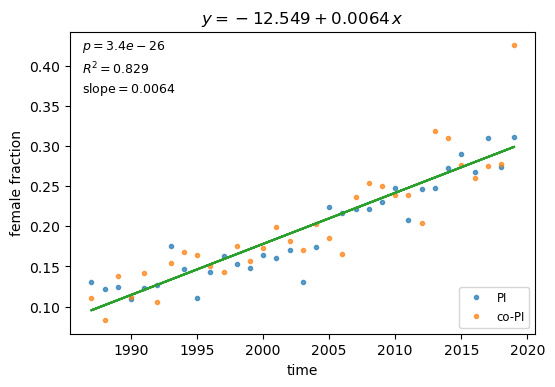

In [9]:
df  = pd.concat([df_pi,df_copi]).reset_index()
lreg_all, X = linreg(df.year, df.fem_frac)
fig, ax = plt.subplots()
_ = ax.plot(df_pi.index, df_pi.fem_frac,'.', label='PI', alpha=0.7)
_ = ax.plot(df_copi.index, df_copi.fem_frac,'.', label='co-PI', alpha=0.7)
_ = ax.plot(df.year, lreg_all.predict(X))
_ = ax.legend(loc='lower right')
p, slope, rsquared = lreg_all.pvalues[1], lreg_all.params[1], lreg_all.rsquared
a, b = lreg_all.params
title = '$y = {:.3f} + {:.2g}\,x$'.format(a, b)
_ = ax.text(0.025,0.95, '$p={:.2g}$'.format(p), transform=ax.transAxes, ha='left',
            va='center', fontsize=9)
_ = ax.text(0.025,0.88, '$R^2={:.3g}$'.format(rsquared), transform=ax.transAxes, ha='left',
            va='center', fontsize=9)
_ = ax.text(0.025,0.81, 'slope$={:.2g}$'.format(slope), transform=ax.transAxes, ha='left',
            va='center', fontsize=9)
_ = ax.set(xlabel='time', ylabel='female fraction', title=title)

## NSF programs

### Top 10 NSF programs in number of awards

The table and histogram below show the top 10 NSF-OCE programs in number of awards for the period 1987-2019.

,number of awards,percentage of total,cum percentage of total
program,,,
MARINE GEOLOGY AND GEOPHYSICS,2577,22.383393,22.383393
BIOLOGICAL OCEANOGRAPHY,2121,18.422653,40.806045
PHYSICAL OCEANOGRAPHY,1835,15.938504,56.744550
CHEMICAL OCEANOGRAPHY,1347,11.699818,68.444367
OCEAN TECH & INTERDISC COORDIN,475,4.125771,72.570138
OCEANOGRAPHIC INSTRUMENTATION,453,3.934683,76.504821
SHIPBOARD SCIENTIFIC SUPP EQUI,377,3.274559,79.779380
OCEAN DRILLING PROGRAM,281,2.440719,82.220099
EDUCATION/HUMAN RESOURCES,249,2.162773,84.382872


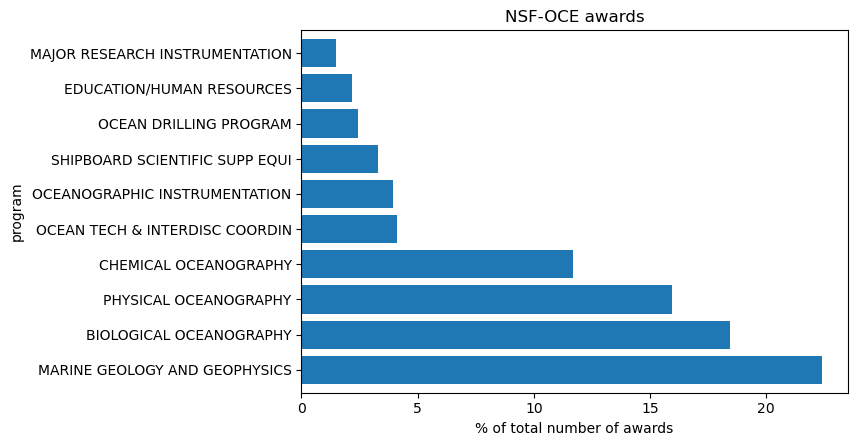

In [10]:
awards.loc[awards.program=='DATA NOT AVAILABLE','program'] = np.nan
top10_programs = pd.DataFrame({'number of awards':
                      awards.groupby('program')['Abstract'].count().sort_values(ascending=False)[:10]})
top10_programs['percentage of total'] = top10_programs['number of awards'] / len(awards) * 100
top10_programs['cum percentage of total'] = top10_programs['percentage of total'].cumsum() 

fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = top10_programs['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total number of awards')

top10_programs

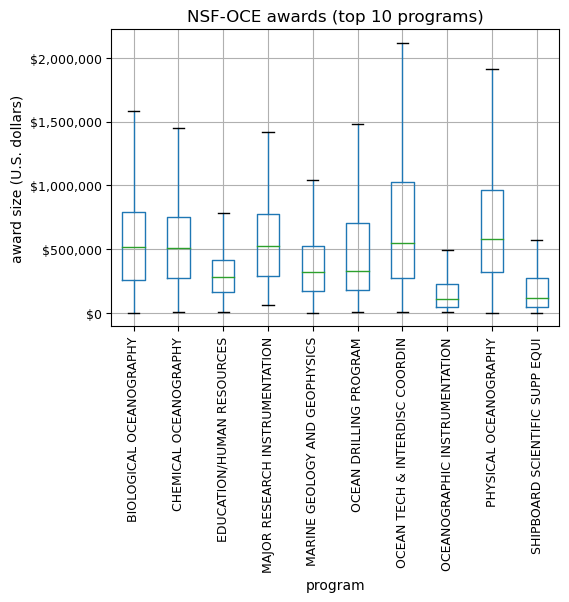

In [11]:
df = awards[awards.program.isin(top10_programs.index)]
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = df.boxplot('tot_amount_adjusted', by='program', showfliers=False, rot=90, fontsize=9, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='NSF-OCE awards (top 10 programs)', ylabel='award size (U.S. dollars)')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.45)

The figure below shows the time series of the number of awards and the percentage of awards per year for each of the top 10 programs.

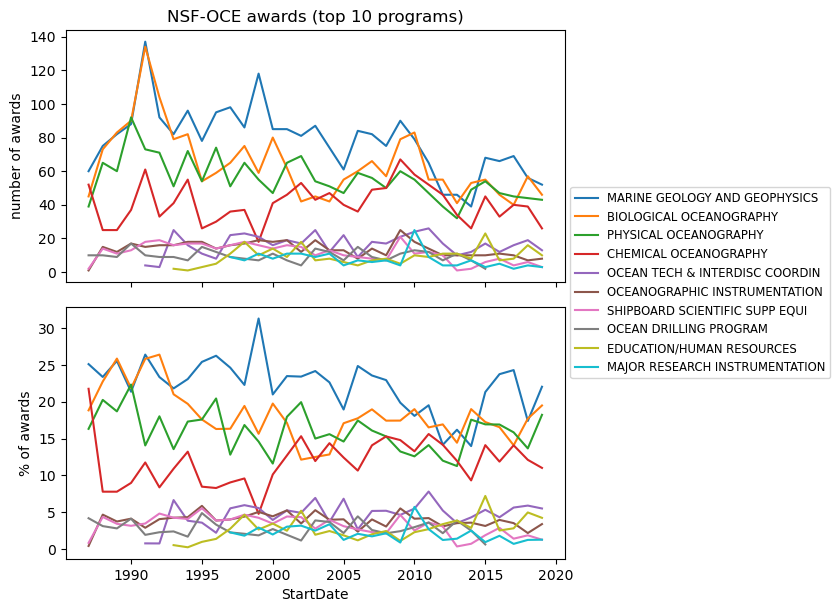

In [12]:
prog_year = awards.groupby([awards.StartDate.dt.year,'program'])['Abstract'].count().unstack()
prog_year = prog_year[top10_programs.index]
num_awards_per_year = awards.groupby([awards.StartDate.dt.year])['Abstract'].count()
prog_year_pct = prog_year.divide(num_awards_per_year,axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, hspace=0.1)
_ = prog_year.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('NSF-OCE awards (top 10 programs)')
_ = prog_year_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of awards')

### Top 10 NSF programs in total amount awarded

The table and histogram below show the top 10 NSF-OCE programs in total amount awarded for the period 1987-2019.

,amount awarded,percentage of total,cum percentage of total
program,,,
PHYSICAL OCEANOGRAPHY,"$1,733,384,196.35",13.022919,13.022919
BIOLOGICAL OCEANOGRAPHY,"$1,497,038,872.21",11.247256,24.270175
MARINE GEOLOGY AND GEOPHYSICS,"$1,305,635,469.81",9.809242,34.079417
OCEAN DRILLING PROGRAM,"$1,184,717,727.14",8.900787,42.980203
SHIP OPERATIONS,"$945,984,461.72",7.107183,50.087386
SODV - CONSTRUCTION,"$847,242,483.59",6.365334,56.452721
CHEMICAL OCEANOGRAPHY,"$788,216,809.37",5.921874,62.374595
OCEAN TECH & INTERDISC COORDIN,"$490,624,932.12",3.686066,66.060661
OCEAN OBSERV INIT-CONSTRUCTION,"$460,170,552.23",3.457262,69.517923


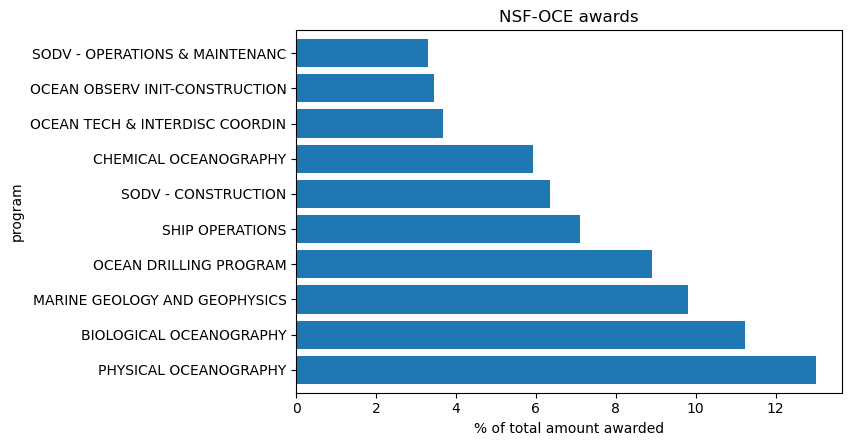

In [13]:
top10_programs_amount = pd.DataFrame({'amount awarded':
    awards.groupby('program')['tot_amount_adjusted'].sum().sort_values(ascending=False)[:10]})
top10_programs_amount['percentage of total'] = (top10_programs_amount['amount awarded'] /
                                         awards.tot_amount_adjusted.sum() * 100)
top10_programs_amount['cum percentage of total'] = top10_programs_amount['percentage of total'].cumsum()

fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = top10_programs_amount['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total amount awarded')

top10_programs_amount.style.format('${0:,.2f}', subset='amount awarded')

The figure below shows the time series of the amount awarded and the percentage of the amount awarded per year for each of the top 10 programs.

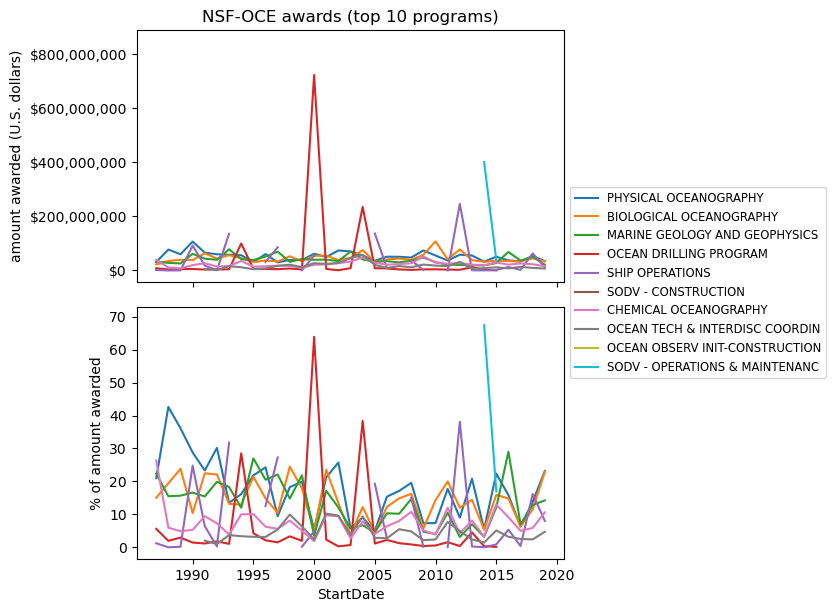

In [14]:
prog_year_amount = awards.groupby(
    [awards.StartDate.dt.year,'program'])['tot_amount_adjusted'].sum().unstack()
prog_year_amount = prog_year_amount[top10_programs_amount.index]
prog_year_amount_pct = prog_year_amount.divide(amount_per_year, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, left=0.2, hspace=0.1)
_ = prog_year_amount.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('NSF-OCE awards (top 10 programs)')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = prog_year_amount_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of amount awarded')

### Gender composition across top 10 programs (in number of awards)

PI gender fraction across top 10 programs.

PI_gender,female,male
program,,
EDUCATION/HUMAN RESOURCES,0.389121,0.610879
BIOLOGICAL OCEANOGRAPHY,0.245480,0.754520
MARINE GEOLOGY AND GEOPHYSICS,0.189231,0.810769
CHEMICAL OCEANOGRAPHY,0.182226,0.817774
MAJOR RESEARCH INSTRUMENTATION,0.157895,0.842105
OCEAN DRILLING PROGRAM,0.157143,0.842857
PHYSICAL OCEANOGRAPHY,0.153089,0.846911
OCEAN TECH & INTERDISC COORDIN,0.140127,0.859873
SHIPBOARD SCIENTIFIC SUPP EQUI,0.039894,0.960106


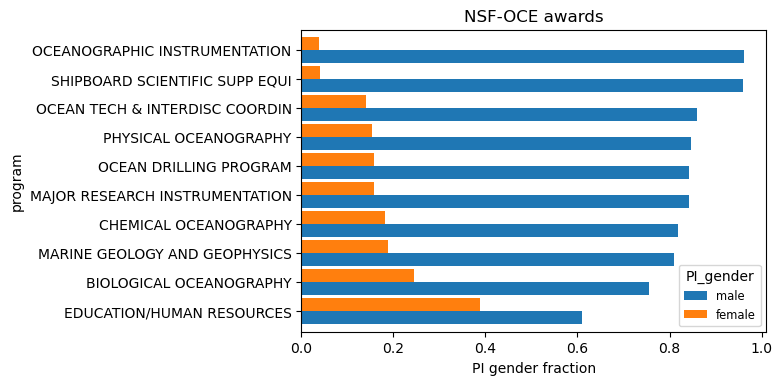

In [15]:
df_prog = awards[awards.program.isin(top10_programs.index)]

df = df_prog.groupby(['program','PI_gender'])['Abstract'].count().unstack()
by_program_pi = df.fillna(0).divide(df.sum(axis=1), axis=0)
by_program_pi = by_program_pi.sort_values('male')

fig, ax = plt.subplots()
_ = by_program_pi[['male','female']].plot(kind='barh', ax=ax, width=0.9)
_ = ax.set(title='NSF-OCE awards', xlabel='PI gender fraction')

by_program_pi

co-PI gender fraction across top 10 programs.

,female,male
program,,
EDUCATION/HUMAN RESOURCES,0.564752,0.435248
BIOLOGICAL OCEANOGRAPHY,0.255762,0.744238
CHEMICAL OCEANOGRAPHY,0.230708,0.769292
MARINE GEOLOGY AND GEOPHYSICS,0.188731,0.811269
PHYSICAL OCEANOGRAPHY,0.176544,0.823456
MAJOR RESEARCH INSTRUMENTATION,0.169403,0.830597
OCEAN TECH & INTERDISC COORDIN,0.158178,0.841822
OCEAN DRILLING PROGRAM,0.143871,0.856129
OCEANOGRAPHIC INSTRUMENTATION,0.102599,0.897401


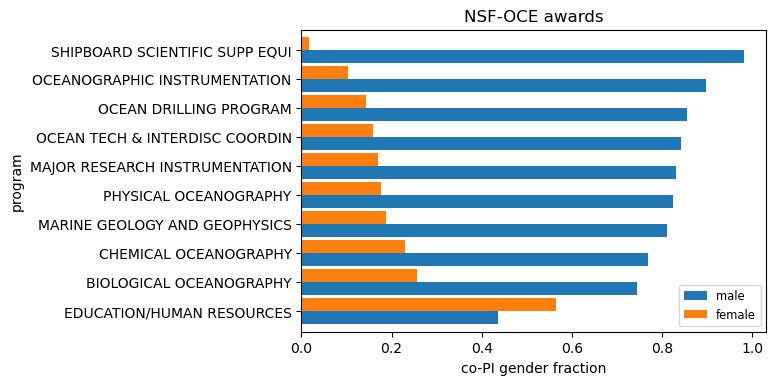

In [16]:
by_program_copi = pd.DataFrame({'female': df_prog.groupby(['program'])['co-PI_female_frac'].mean()})
by_program_copi['male'] = 1 - by_program_copi.female
by_program_copi = by_program_copi.sort_values('male')

fig, ax = plt.subplots()
_ = by_program_copi[['male','female']].plot(kind='barh', ax=ax, width=0.9)
_ = ax.set(title='NSF-OCE awards', xlabel='co-PI gender fraction')

by_program_copi

### Changes in gender composition across top 10 programs (in number of awards)

The figure below shows time series of the annual fraction of female PIs and co-PIs for each of the top 10 NSF-OCE programs (in number of awards). Solid lines represent the linear regression fit and points represent the individual years. If the p-value for the regression slope is not significant ($p<0.05$) the regression line is not plotted. The table shows the linear regressions results.

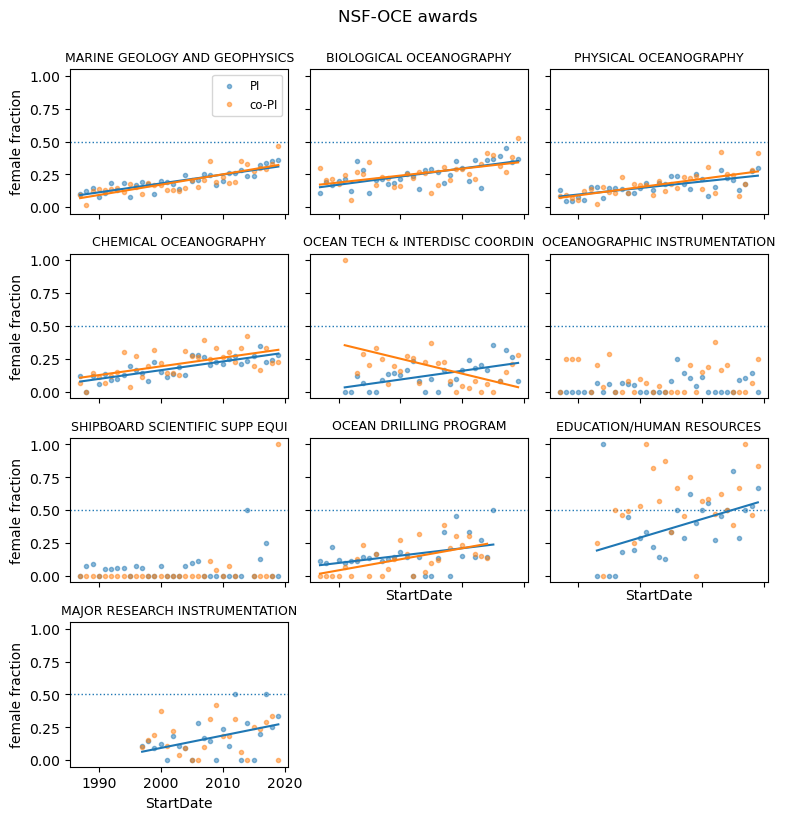

In [17]:
# female & male fraction of PIs
df = df_prog.groupby(['program',df_prog.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_by_program = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender_by_program = pd.DataFrame({'female': 
                   df_prog.groupby(['program',df_prog.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_by_program['male'] = 1 - copi_gender_by_program.female

# female fraction of PIs & co-PIs
female_frac_by_program = pd.DataFrame({'PI':pi_gender_by_program['female'],
                                       'co-PI':copi_gender_by_program['female']})
# female_frac_by_program = female_frac_by_program - 0.5
nn = 3 # size of moving window (years)
alpha = 0.5

# fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(7, 9))
fig, axs = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(9, 9))
fig.delaxes(axs[3,1])
fig.delaxes(axs[3,2])
fig.subplots_adjust(hspace=0.275, wspace=0.1, top=0.9)
params = []
for ax, prog in zip(axs.ravel(), top10_programs.index):
    if prog == 'MARINE GEOLOGY AND GEOPHYSICS':
        legend = True
    else:
        legend=False
    _ = female_frac_by_program.loc[prog].plot(ax=ax, style=['C0.','C1.'],legend=legend, alpha=alpha)
#     _ = female_frac_by_program.loc[prog].rolling(nn, center=True).mean().plot(ax=ax, legend=legend)

    reg1, X = linreg(female_frac_by_program.loc[prog].index, female_frac_by_program.loc[prog].PI)
    if reg1.pvalues[1]<0.05:
        _ = ax.plot(female_frac_by_program.loc[prog].index, reg1.predict(X), 'C0')
    reg2, X = linreg(female_frac_by_program.loc[prog].dropna().index, female_frac_by_program.loc[prog,'co-PI'].dropna())
    if reg2.pvalues[1]<0.05:
        _ = ax.plot(female_frac_by_program.loc[prog].dropna().index, reg2.predict(X), 'C1')

    params.append([reg1.rsquared,reg1.params[1],reg1.pvalues[1],reg2.rsquared,reg2.params[1],reg2.pvalues[1]])

    _ = ax.set_title(prog, fontsize=9)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)    
for i in range(4):
    _ = axs[i,0].set_ylabel('female fraction')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

lr_stats = pd.DataFrame(np.array(params), index=top10_programs.index,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.4f}', subset=['PI','co-PI'])

The results from the regression below show that the difference in mean female fraction (intercept) between PIs and co-PIs in CHEMICAL OCEANOGRAPHY is not statistically significant.

In [18]:
prog = 'CHEMICAL OCEANOGRAPHY'
# for prog in top10_programs.index:
#     print('\n'+prog)
df1 = pd.DataFrame({'fem_frac':female_frac_by_program.loc[prog,'PI'], 'category':'PI'})
df2 = pd.DataFrame({'fem_frac':female_frac_by_program.loc[prog,'co-PI'], 'category':'co-PI'})
df  = pd.concat([df1,df2]).reset_index()
df.rename(columns={'StartDate': 'year'},inplace=True)
lreg = smf.ols(formula='fem_frac ~ year + category', data=df)
# lreg = smf.ols(formula='fem_frac ~ year + category + year:category', data=df)
res = lreg.fit()
res.summary()
#     print(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fem_frac   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     31.14
Date:                Tue, 03 Nov 2020   Prob (F-statistic):           3.94e-10
Time:                        21:23:44   Log-Likelihood:                 86.520
No. Observations:                  66   AIC:                            -167.0
Df Residuals:                      63   BIC:                            -160.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -13.1148      1.729     -7.586      0.000     -16.570      -9.660
category[T.co-PI]     0.0290      0.016      1.767      0.082      -0.004       0.062
year                  0.0066      0.001      7.692      0.000       0.005       0.008
==============================================================================
Omnibus:                        1.000   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.607   Jarque-Bera (JB):                1.028
Skew:                           0.276   Prob(JB):                        0.598
Kurtosis:                       2.739   Cond. No.                     4.21e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
# fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9,8))
# for ax, prog in zip(axs.ravel(),
#                     ['MARINE GEOLOGY AND GEOPHYSICS','BIOLOGICAL OCEANOGRAPHY', 'PHYSICAL OCEANOGRAPHY', 'CHEMICAL OCEANOGRAPHY']):
#     df = female_frac_by_program.loc[prog]
#     _ = sns.regplot(df.index, df.PI, ax=ax)
#     _ = sns.regplot(df.index, df['co-PI'], ax=ax)
#     _ = ax.set_title(prog)

## Academic organizations

### Top 10 academic organizations in number of awards

In [20]:
# shorten some organization names
awards.loc[awards.Organization == 'University of Miami Rosenstiel School of Marine&Atmospheric Sci',
           'Organization'] = 'University of Miami RSMAS'
awards.loc[awards.Organization == 'University of California-San Diego Scripps Inst of Oceanography',
           'Organization'] = 'UCSD Scripps Institution of Oceanography'

The table and histogram below show the top 10 academic organizations in number of awards for the period 1987-2019.

,number of awards,percentage of total,cum percentage of total
Organization,,,
Woods Hole Oceanographic Institution,1600,13.897333,13.897333
UCSD Scripps Institution of Oceanography,807,7.009468,20.906801
Columbia University,602,5.228872,26.135673
University of Washington,598,5.194128,31.329801
Oregon State University,569,4.942239,36.272040
University of Hawaii,502,4.360288,40.632329
University of Miami RSMAS,323,2.805524,43.437853
University of Rhode Island,299,2.597064,46.034917
University of Delaware,198,1.719795,47.754712


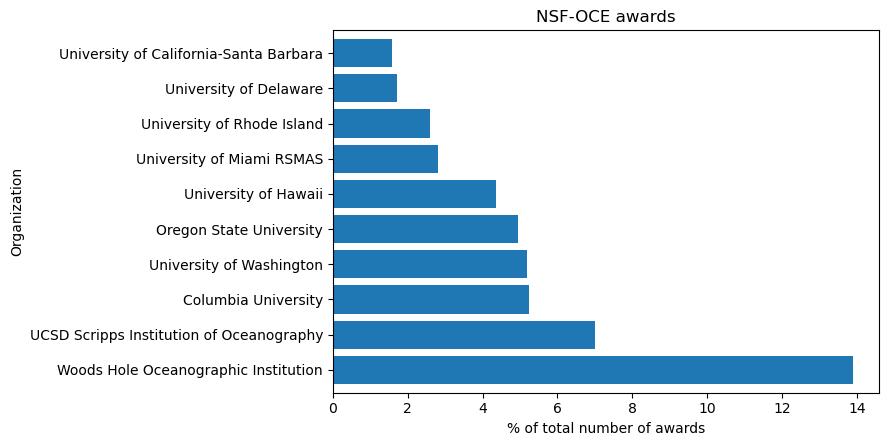

In [21]:
top10_orgs = pd.DataFrame(
    {'number of awards':
     awards.groupby('Organization')['Abstract'].count().sort_values(ascending=False)[:10]})
top10_orgs['percentage of total'] = top10_orgs['number of awards']/len(awards)*100
top10_orgs['cum percentage of total'] = top10_orgs['percentage of total'].cumsum()

fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = top10_orgs['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total number of awards')

top10_orgs

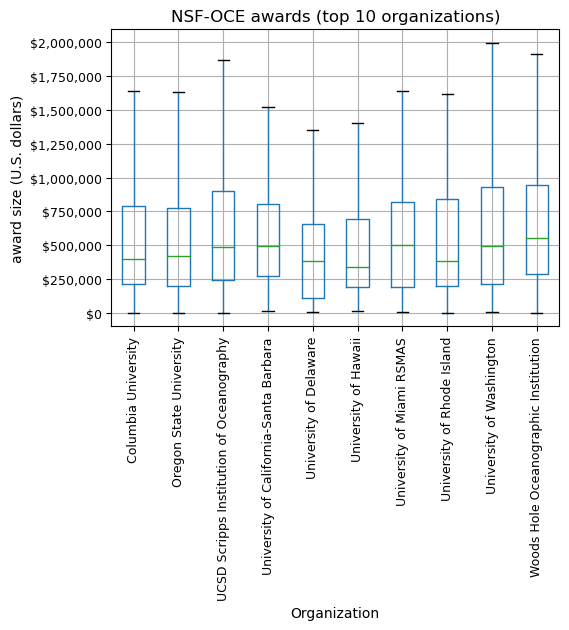

In [22]:
df = awards[awards.Organization.isin(top10_orgs.index)]
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = df.boxplot('tot_amount_adjusted', by='Organization', showfliers=False, rot=90, fontsize=9, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='NSF-OCE awards (top 10 organizations)', ylabel='award size (U.S. dollars)')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.45)

The figure below shows the time series of the number of awards and the percentage of awards per year for each of the top 10 organizations.

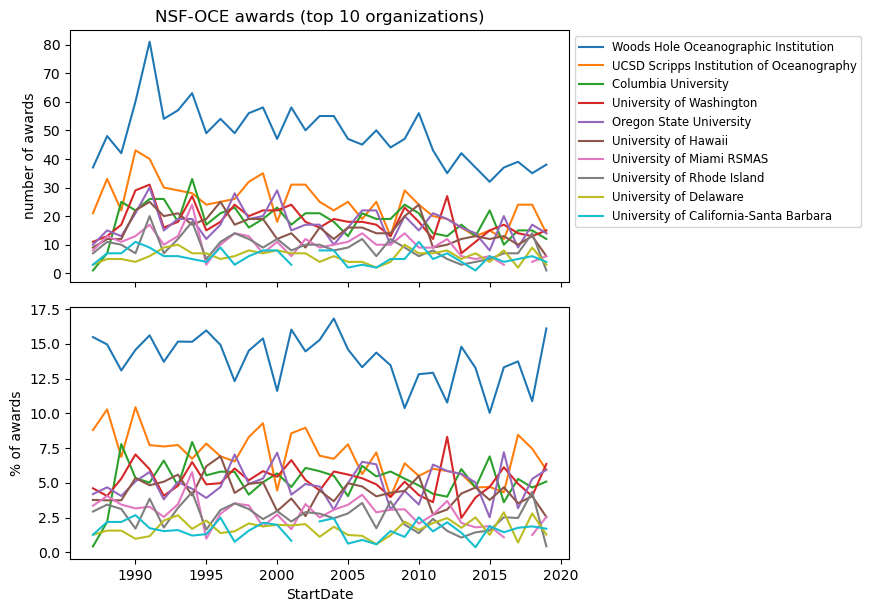

In [23]:
org_year = awards.groupby([awards.StartDate.dt.year,'Organization'])['Abstract'].count().unstack()
org_year = org_year[top10_orgs.index]
org_year_pct = org_year.divide(num_awards_per_year,axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, hspace=0.1)
_ = org_year.plot(ax=axs[0]).legend(bbox_to_anchor=(1, 1))
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('NSF-OCE awards (top 10 organizations)')
_ = org_year_pct.plot(ax=axs[1], legend=False)
_ = axs[1].set_ylabel('% of awards')

### Top 10 academic organizations in total amount awarded

The table and histogram below show the top 10 academic organizations in total amount awarded for the period 1987-2019.

,amount awarded,percentage of total,cum percentage of total
Organization,,,
"Consortium for Ocean Leadership, Inc","$2,566,628,770.88",19.283087,19.283087
Woods Hole Oceanographic Institution,"$2,173,323,408.21",16.328183,35.611270
UCSD Scripps Institution of Oceanography,"$984,540,895.39",7.396858,43.008128
Oregon State University,"$775,361,298.13",5.825291,48.833419
Columbia University,"$719,521,492.45",5.405766,54.239185
University of Washington,"$557,513,396.54",4.188599,58.427784
Texas A&M Research Foundation,"$462,583,353.02",3.475390,61.903174
University of Hawaii,"$449,643,249.02",3.378171,65.281344
University of Alaska Fairbanks Campus,"$348,221,594.82",2.616190,67.897534


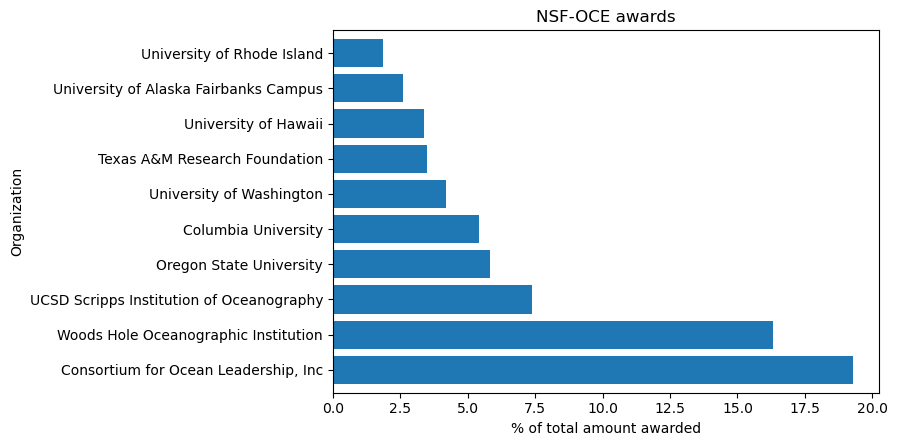

In [24]:
top10_orgs_amount = pd.DataFrame(
    {'amount awarded':
     awards.groupby('Organization')['tot_amount_adjusted'].sum().sort_values(ascending=False)[:10]})
top10_orgs_amount['percentage of total'] = (top10_orgs_amount['amount awarded']/
                                     awards.tot_amount_adjusted.sum()*100)
top10_orgs_amount['cum percentage of total'] = top10_orgs_amount['percentage of total'].cumsum()

fig, ax = plt.subplots(figsize=(9.5, 4.8))
fig.subplots_adjust(left=0.325)
_ = top10_orgs_amount['percentage of total'].plot(kind='barh',ax=ax, width=0.8)
_ = ax.set(title='NSF-OCE awards', xlabel='% of total amount awarded')

top10_orgs_amount.style.format('${0:,.2f}', subset='amount awarded')

The figure below shows the time series of the amount awarded and percentage of the amount awarded per year for each of the top 10 organizations.

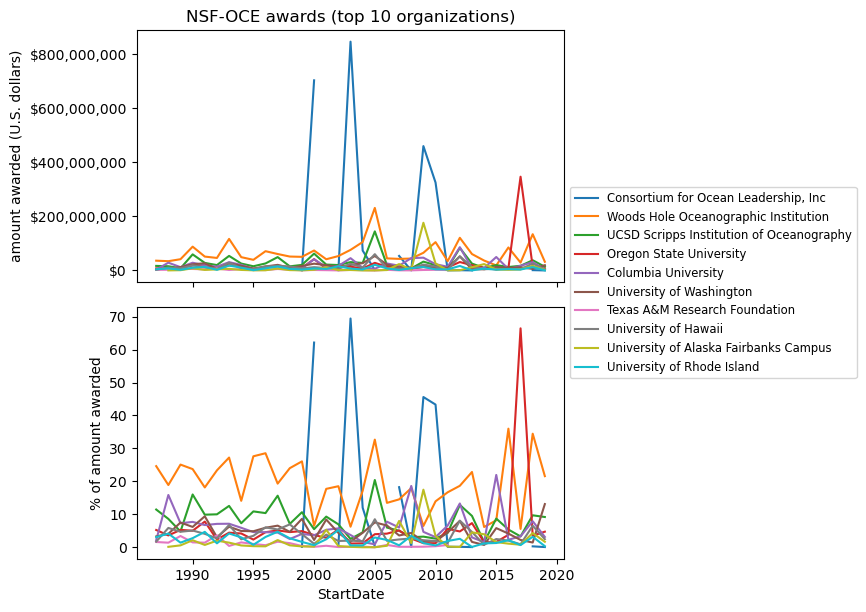

In [25]:
org_year_amount = awards.groupby(
    [awards.StartDate.dt.year,'Organization'])['tot_amount_adjusted'].sum().unstack()
org_year_amount = org_year_amount[top10_orgs_amount.index[0:]]
org_year_amount_pct = org_year_amount.divide(amount_per_year, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, left=0.2, hspace=0.1)
_ = org_year_amount.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('NSF-OCE awards (top 10 organizations)')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = org_year_amount_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of amount awarded')

### Gender composition across top 10 organizations (in number of awards)

PI gender fraction across top 10 organizations.

PI_gender,female,male
Organization,,
University of Rhode Island,0.242424,0.757576
University of California-Santa Barbara,0.193370,0.806630
Woods Hole Oceanographic Institution,0.178125,0.821875
University of Miami RSMAS,0.176471,0.823529
UCSD Scripps Institution of Oceanography,0.166253,0.833747
Columbia University,0.158598,0.841402
University of Hawaii,0.135458,0.864542
University of Washington,0.126904,0.873096
Oregon State University,0.118584,0.881416


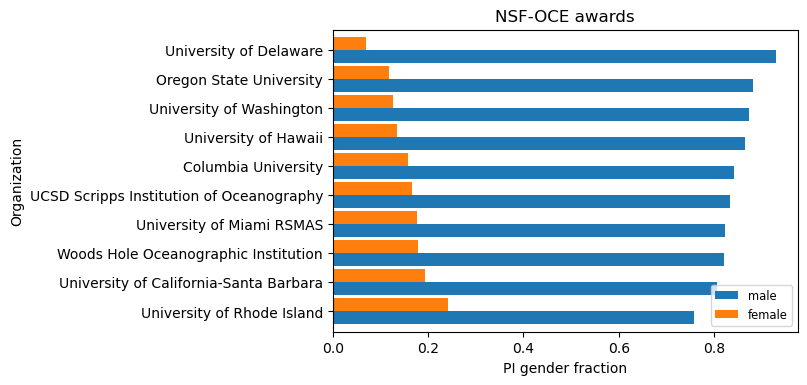

In [26]:
df_org = awards[awards.Organization.isin(top10_orgs.index)]

df = df_org.groupby(['Organization','PI_gender'])['Abstract'].count().unstack()
by_org_pi = df.fillna(0).divide(df.sum(axis=1), axis=0)
by_org_pi = by_org_pi.sort_values('male')

fig, ax = plt.subplots()
_ = by_org_pi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(bbox_to_anchor=(0.8, 0.175))
_ = ax.set(title='NSF-OCE awards', xlabel='PI gender fraction')

by_org_pi

co-PI gender fraction across top 10 organizations.

,female,male
Organization,,
University of California-Santa Barbara,0.230175,0.769825
University of Rhode Island,0.216507,0.783493
University of Washington,0.213203,0.786797
Woods Hole Oceanographic Institution,0.210472,0.789528
University of Miami RSMAS,0.199919,0.800081
Oregon State University,0.190384,0.809616
Columbia University,0.169390,0.830610
UCSD Scripps Institution of Oceanography,0.163272,0.836728
University of Hawaii,0.125490,0.874510


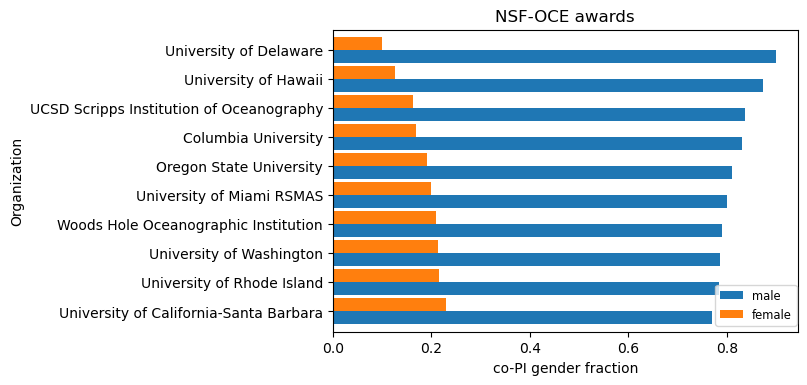

In [27]:
by_org_copi = pd.DataFrame({'female': df_org.groupby(['Organization'])['co-PI_female_frac'].mean()})
by_org_copi['male'] = 1 - by_org_copi.female
by_org_copi = by_org_copi.sort_values('male')

fig, ax = plt.subplots()
_ = by_org_copi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(bbox_to_anchor=(0.81, 0.175))
_ = ax.set(title='NSF-OCE awards', xlabel='co-PI gender fraction')

by_org_copi

### Changes in gender composition across top 10 organizations (in number of awards)

The figure below shows time series of the annual fraction of female PIs and co-PIs for each of the top 10 academic organizations (in number of awards). Solid lines represent the linear regression fit and points represent the individual years. If the p-value for the regression slope is not significant ($p<0.05$) the regression line is not plotted. The table shows the linear regressions results.

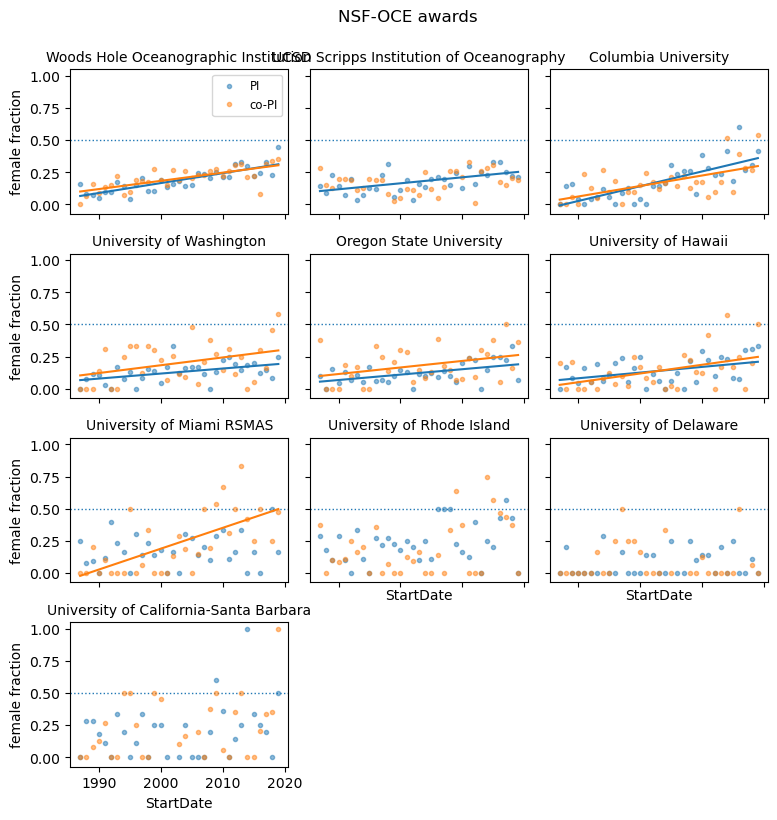

In [28]:
# female & male fraction of PIs
df = df_org.groupby(['Organization',df_org.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_by_org = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender_by_org = pd.DataFrame({'female': 
                   df_org.groupby(['Organization',df_org.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_by_org['male'] = 1 - copi_gender_by_org.female

female_frac_by_org = pd.DataFrame({'PI':pi_gender_by_org['female'], 'co-PI': copi_gender_by_org['female']})

# fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(7, 9))
fig, axs = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(9, 9))
fig.delaxes(axs[3,1])
fig.delaxes(axs[3,2])
fig.subplots_adjust(hspace=0.275, wspace=0.1, top=0.9)
params = []
for ax, org in zip(axs.ravel(), top10_orgs.index):
    if org == 'Woods Hole Oceanographic Institution':
        legend = True
    else:
        legend=False
    _ = female_frac_by_org.loc[org].plot(ax=ax, style=['C0.','C1.'], legend=legend, alpha=alpha)
#     _ = female_frac_by_org.loc[org].rolling(nn,center=True).mean().plot(ax=ax, legend=legend)

    reg1, X = linreg(female_frac_by_org.loc[org].index, female_frac_by_org.loc[org].PI)
    if reg1.pvalues[1]<0.05:
        _ = ax.plot(female_frac_by_org.loc[org].index, reg1.predict(X), 'C0')
    reg2, X = linreg(female_frac_by_org.loc[org].dropna().index, female_frac_by_org.loc[org,'co-PI'].dropna())
    if reg2.pvalues[1]<0.05:
        _ = ax.plot(female_frac_by_org.loc[org].dropna().index, reg2.predict(X), 'C1')
    params.append([reg1.rsquared,reg1.params[1],reg1.pvalues[1],reg2.rsquared,reg2.params[1],reg2.pvalues[1]])

    _ = ax.set_title(org, fontsize=10)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)    
for i in range(4):
    _ = axs[i,0].set_ylabel('female fraction')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

lr_stats = pd.DataFrame(np.array(params), index=top10_orgs.index,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.4f}', subset=['PI','co-PI'])

## Research topics

Similarly to what was done in [Lima & Rheuban, 2018](https://tos.org/oceanography/article/topics-and-trends-in-nsf-ocean-sciences-awards), we applied non-negative matrix factorization (NMF) to the NSF-OCE abstracts to extract 22 research topics.

### Gender composition across research topics

PI gender fraction across research topics.

PI_gender,female,male
topic,,
17,0.308357,0.691643
18,0.305590,0.694410
8,0.303644,0.696356
7,0.293375,0.706625
21,0.271903,0.728097
6,0.241840,0.758160
10,0.231221,0.768779
9,0.222222,0.777778
11,0.211618,0.788382


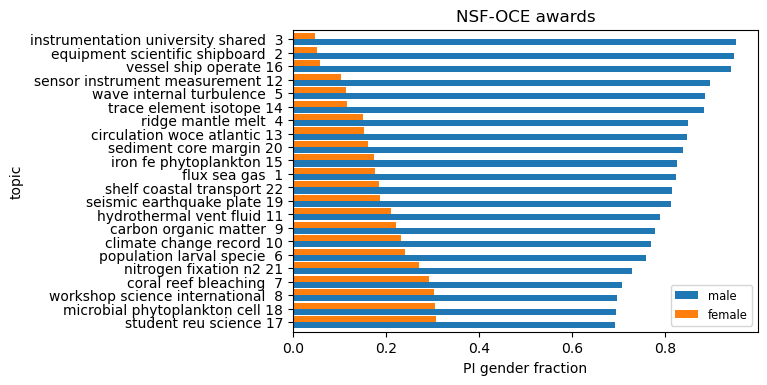

In [29]:
df = awards.groupby(['topic','PI_gender'])['Abstract'].count().unstack()
by_topic_pi = df.fillna(0).divide(df.sum(axis=1), axis=0)
by_topic_pi = by_topic_pi.sort_values('male')

fig, ax = plt.subplots()
_ = by_topic_pi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(bbox_to_anchor=(0.8, 0.175))
_ = ax.set(title='NSF-OCE awards', xlabel='PI gender fraction')
_ = ax.set_yticklabels(topic_names[by_topic_pi.index.values-1])

by_topic_pi

co-PI gender fraction across research topics.

,female,male
topic,,
17,0.449647,0.550353
8,0.325281,0.674719
7,0.316559,0.683441
18,0.281857,0.718143
21,0.269567,0.730433
10,0.264600,0.735400
13,0.258279,0.741721
9,0.234455,0.765545
15,0.230675,0.769325


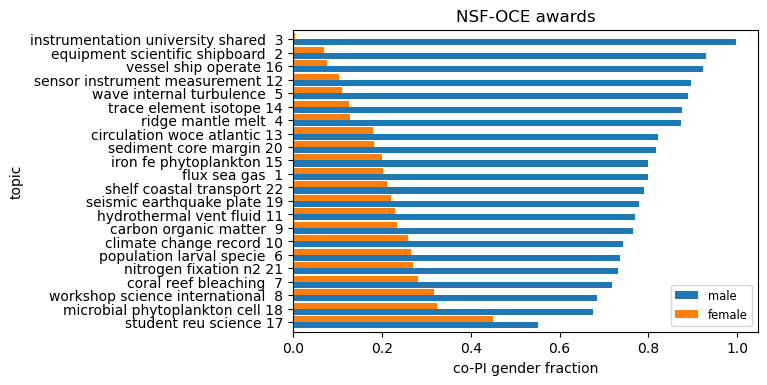

In [30]:
by_topic_copi = pd.DataFrame({'female':awards.groupby(['topic'])['co-PI_female_frac'].mean()})
by_topic_copi['male'] = 1 - by_topic_copi.female
by_topic_copi = by_topic_copi.sort_values('male')

fig, ax = plt.subplots()
_ = by_topic_copi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(bbox_to_anchor=(0.8, 0.175))
_ = ax.set(title='NSF-OCE awards', xlabel='co-PI gender fraction')
_ = ax.set_yticklabels(topic_names[by_topic_pi.index.values-1])

by_topic_copi

### Changes in gender composition across research topics

The figure below shows time series of the annual fraction of female PIs and co-PIs for each of the identified research topics. Solid lines represent the linear regression fit and points represent the individual years. If the p-value for the regression slope is not significant ($p<0.05$) the regression line is not plotted. The table shows the linear regressions results.

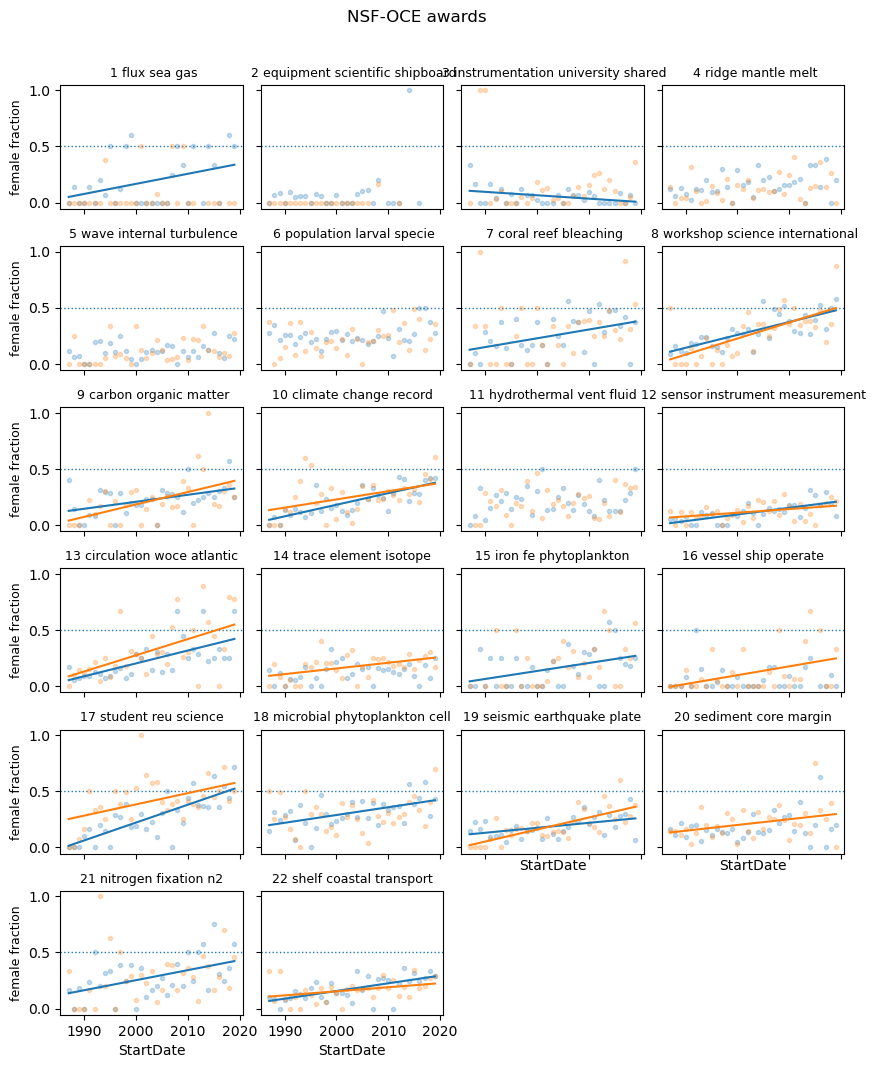

In [31]:
df = awards.groupby(['topic',awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_by_topic = df.fillna(0).divide(df.sum(axis=1), axis=0)

copi_gender_by_topic = pd.DataFrame(
    {'female':awards.groupby(['topic', awards.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_by_topic['male'] = 1 - copi_gender_by_topic.female
copi_gender_by_topic

female_frac_by_topic = pd.DataFrame({'PI':pi_gender_by_topic.female, 'co-PI':copi_gender_by_topic.female})

fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(9.5,12))
fig.subplots_adjust(hspace=0.3, wspace=0.1, top=0.9, right=0.95)
fig.delaxes(axs[5,3])
fig.delaxes(axs[5,2])
params = []
for ax, t in zip(axs.ravel(), range(1,23)):
    if t == 2:
        legend = True
    else:
        legend=False    
    _ = female_frac_by_topic.loc[t].plot(ax=ax, style=['C0.','C1.'], legend=False, alpha=0.25)
#     _ = female_frac_by_topic.loc[t].rolling(nn,center=True).mean().plot(ax=ax, legend=legend)

    reg1, X = linreg(female_frac_by_topic.loc[t].index, female_frac_by_topic.loc[t].PI)
    if reg1.pvalues[1]<0.05:
        _ = ax.plot(female_frac_by_topic.loc[t].index, reg1.predict(X), 'C0')
    reg2, X = linreg(female_frac_by_topic.loc[t].dropna().index, female_frac_by_topic.loc[t,'co-PI'].dropna())
    if reg2.pvalues[1]<0.05:
        _ = ax.plot(female_frac_by_topic.loc[t].dropna().index, reg2.predict(X), 'C1')
    params.append([reg1.rsquared,reg1.params[1],reg1.pvalues[1],reg2.rsquared,reg2.params[1],reg2.pvalues[1]])

    _ = ax.set_title(topic_names_r[t-1], fontsize=9)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)
for i in range(6):
    _ = axs[i,0].set_ylabel('female fraction', fontsize=9)
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

lr_stats = pd.DataFrame(np.array(params), index=topic_names_r,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.4f}', subset=['PI','co-PI'])

## Award types

Types of awards and initiatives identified in the data include:

- Collaborative Research
- EAGER: EArly-concept Grant For Exploratory Research
- RAPID: Rapid Response Research
- REU: Research Experience for Undergraduates
- RUI: Research in Undergraduate Institutions
- SGER: Small Grants for Exploratory Research
- CAREER: Faculty Early Career Development
- CMG: Collaboration in Mathematical Geosciences
- POWRE: Professional Opportunities for Women in Research and Education

SGER seems to be an older denomination for EAGER awards. Therefore we are grouping these two types of awards together as EAGER awards.

In [32]:
# awards = awards.drop('award_type', axis=1)
awards.loc[awards.Title.str.contains('collaborative\s'),'award_type'] = 'Collaborative Research'
awards.loc[awards.Title.str.contains('eager\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('rapid\s'),'award_type'] = 'RAPID'
awards.loc[awards.Title.str.contains('sger\s'),'award_type'] = 'EAGER'
awards.loc[awards.Title.str.contains('reu\s'),'award_type'] = 'REU'
awards.loc[awards.Title.str.contains('rui\s'),'award_type'] = 'RUI'
awards.loc[awards.Title.str.contains('career\s'),'award_type'] = 'CAREER'
awards.loc[awards.Title.str.contains('cmg\s'),'award_type'] = 'CMG'
awards.loc[awards.Title.str.contains('powre\s'),'award_type'] = 'POWRE'
awards['award_type'] = awards.award_type.fillna('standard')

### Number of awards

In [33]:
atypes = pd.DataFrame({'number of awards': awards.award_type.value_counts()})
atypes['percentage of total'] =  atypes['number of awards'] / len(awards) * 100
atypes['cum percentage of total'] = atypes['percentage of total'].cumsum()
atypes

,number of awards,percentage of total,cum percentage of total
standard,8468,73.551637,73.551637
Collaborative Research,1987,17.258751,90.810388
EAGER,348,3.022670,93.833058
RAPID,245,2.128029,95.961087
REU,236,2.049857,98.010944
CAREER,108,0.938070,98.949014
RUI,88,0.764353,99.713367
CMG,20,0.173717,99.887084
POWRE,13,0.112916,100.000000


The number and percentage of each award type in each year between 1987 2019.

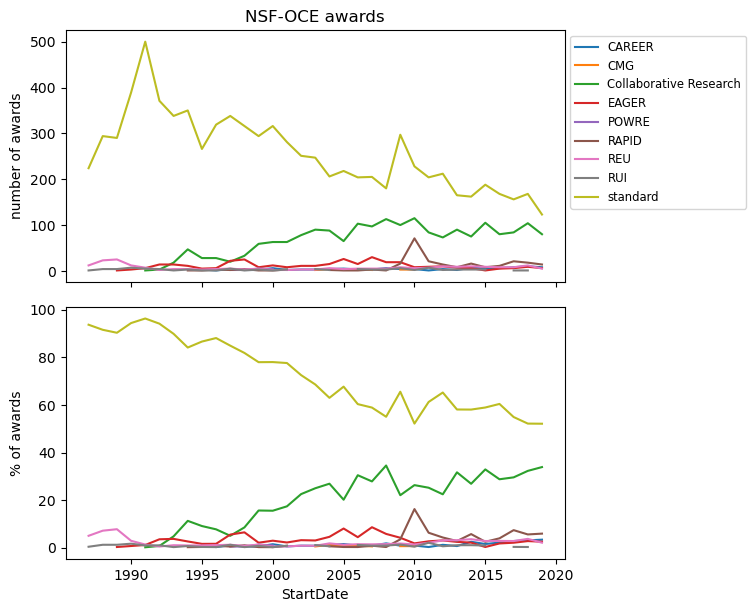

In [34]:
atype_year = awards.groupby([awards.StartDate.dt.year,'award_type'])['Abstract'].count().unstack()
atype_year_pct = atype_year.divide(num_awards_per_year,axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, hspace=0.1)
_ = atype_year.plot(ax=axs[0]).legend(bbox_to_anchor=(1, 1))
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('NSF-OCE awards')
_ = atype_year_pct.plot(ax=axs[1], legend=False)
_ = axs[1].set_ylabel('% of awards')

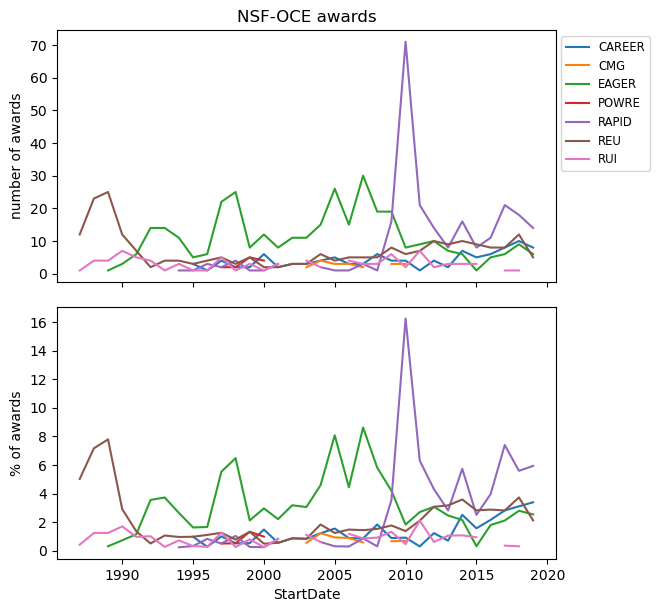

In [35]:
types = ['CAREER','CMG','EAGER','POWRE','RAPID','REU','RUI']
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, hspace=0.1)
_ = atype_year[types].plot(ax=axs[0]).legend(bbox_to_anchor=(1.2, 1))
_ = axs[0].set_ylabel('number of awards')
_ = axs[0].set_title('NSF-OCE awards')
_ = atype_year_pct[types].plot(ax=axs[1], legend=False)
_ = axs[1].set_ylabel('% of awards')

### Amount awarded

In [36]:
atype_amount = pd.DataFrame(
    {'amount awarded':
     awards.groupby('award_type')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
atype_amount['percentage of total'] = (atype_amount['amount awarded'] / atype_amount['amount awarded'].sum()
                                       * 100)
atype_amount.style.format('${0:,.2f}', subset='amount awarded')

,amount awarded,percentage of total
award_type,,
standard,"$11,057,799,224.07",83.077267
Collaborative Research,"$1,923,593,290.87",14.451960
REU,"$102,516,226.11",0.770205
RAPID,"$64,599,009.39",0.485332
CAREER,"$64,394,968.02",0.483800
EAGER,"$42,035,650.80",0.315814
RUI,"$36,333,626.48",0.272975
CMG,"$17,435,101.69",0.130990
POWRE,"$1,551,679.18",0.011658


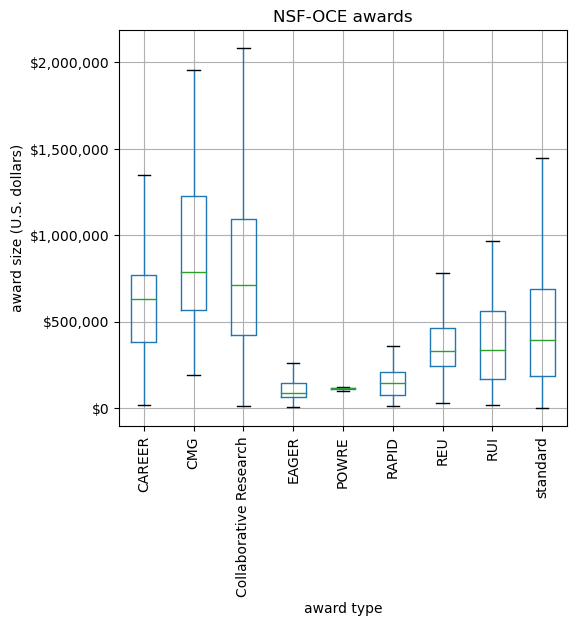

In [37]:
fig, ax = plt.subplots(figsize=(6.4, 6.6))
_ = awards.boxplot('tot_amount_adjusted', by='award_type', showfliers=False, rot=90, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(title='NSF-OCE awards', ylabel='award size (U.S. dollars)', xlabel='award type')
fig.suptitle('')
fig.subplots_adjust(left=0.2, bottom=0.3)

The annual amount awarded and percentage of annual amount awarded for each award type between 1987 2019.

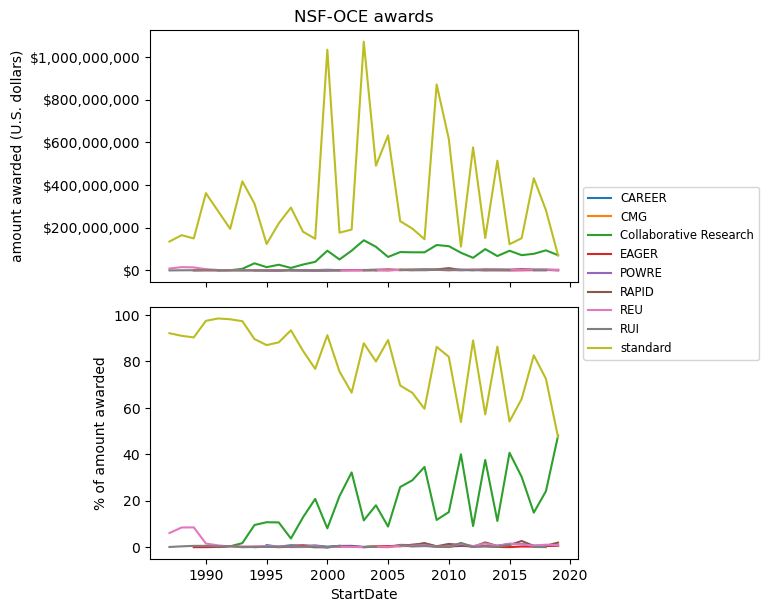

In [38]:
atype_year_amount = awards.groupby(
    [awards.StartDate.dt.year,'award_type'])['tot_amount_adjusted'].sum().unstack()
atype_year_amount_pct = atype_year_amount.divide(amount_per_year, axis=0) * 100

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, left=0.2, hspace=0.1)
_ = atype_year_amount.plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('NSF-OCE awards')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = atype_year_amount_pct.plot(ax=axs[1]).legend(bbox_to_anchor=(1, 1.5))
_ = axs[1].set_ylabel('% of amount awarded')

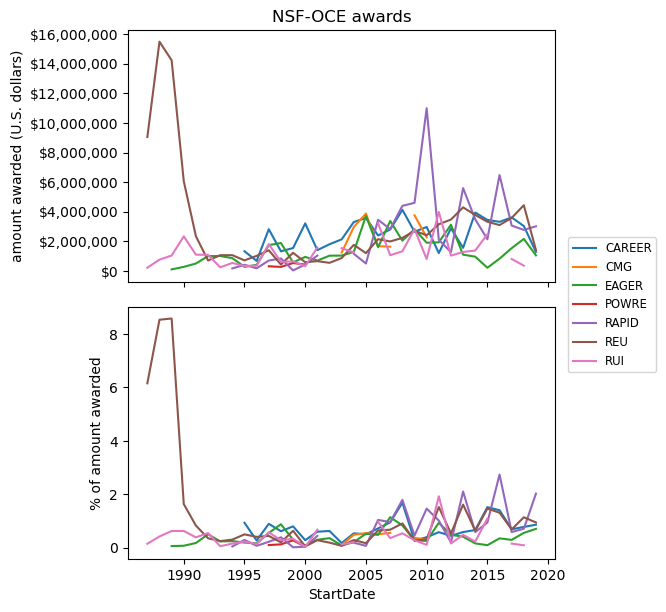

In [39]:
types = ['CAREER','CMG','EAGER','POWRE','RAPID','REU','RUI']
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9.5,7))
fig.subplots_adjust(right=0.65, left=0.2, hspace=0.1)
_ = atype_year_amount[types].plot(ax=axs[0], legend=False)
_ = axs[0].set_ylabel('amount awarded (U.S. dollars)')
_ = axs[0].set_title('NSF-OCE awards')
_ = axs[0].yaxis.set_major_formatter(fmt)
_ = atype_year_amount_pct[types].plot(ax=axs[1]).legend(bbox_to_anchor=(1.25, 1.3))
_ = axs[1].set_ylabel('% of amount awarded')

### Gender composition across award types

PI gender fraction across award types.

PI_gender,female,male
award_type,,
POWRE,1.000000,0.000000
CAREER,0.342593,0.657407
REU,0.292373,0.707627
RUI,0.261364,0.738636
RAPID,0.260331,0.739669
Collaborative Research,0.228645,0.771355
EAGER,0.219653,0.780347
standard,0.168589,0.831411
CMG,0.000000,1.000000


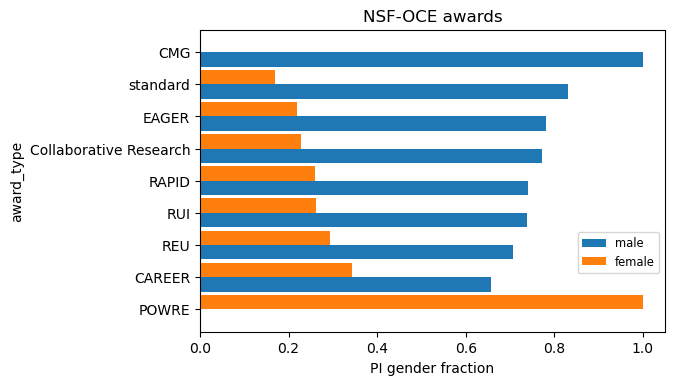

In [40]:
df = awards.groupby(['award_type','PI_gender'])['Abstract'].count().unstack()
by_atype_pi = df.fillna(0).divide(df.sum(axis=1), axis=0)
by_atype_pi = by_atype_pi.sort_values('male')

fig, ax = plt.subplots()
_ = by_atype_pi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(bbox_to_anchor=(0.8, 0.175))
_ = ax.set(title='NSF-OCE awards', xlabel='PI gender fraction')

by_atype_pi

co-PI gender fraction across award types.

,female,male
award_type,,
CAREER,0.583333,0.416667
REU,0.452719,0.547281
EAGER,0.310219,0.689781
RAPID,0.296086,0.703914
RUI,0.285714,0.714286
CMG,0.281250,0.718750
Collaborative Research,0.235995,0.764005
standard,0.176553,0.823447
POWRE,NaN,NaN


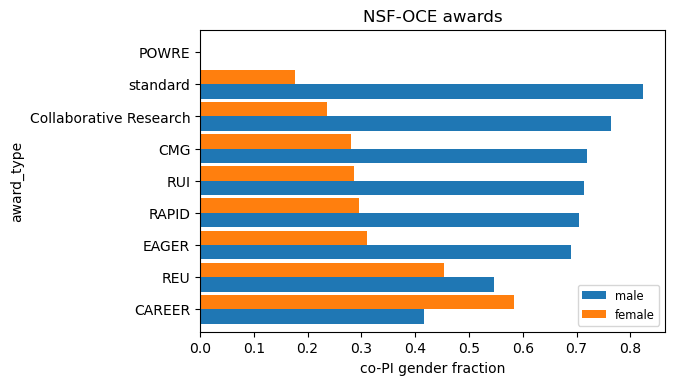

In [41]:
by_atype_copi = pd.DataFrame({'female': awards.groupby(['award_type'])['co-PI_female_frac'].mean()})
by_atype_copi['male'] = 1 - by_atype_copi.female
by_atype_copi = by_atype_copi.sort_values('male')

fig, ax = plt.subplots()
_ = by_atype_copi[['male','female']].plot(kind='barh', ax=ax, width=0.9).legend(bbox_to_anchor=(0.8, 0.175))
_ = ax.set(title='NSF-OCE awards', xlabel='co-PI gender fraction')

by_atype_copi

### Changes in gender composition across award types

The figure below shows time series of the annual fraction of female PIs and co-PIs for each NSF-OCE award types. Solid lines represent the linear regression fit and points represent the individual years. If the p-value for the regression slope is not significant ($p<0.05$) the regression line is not plotted. The table shows the linear regressions results.

Except for *Collaborative Research* and *standard* awards, the number of awards per year in each award type is small, therefore the variability is high. Many award types don't have enough points to fit a linear regression.

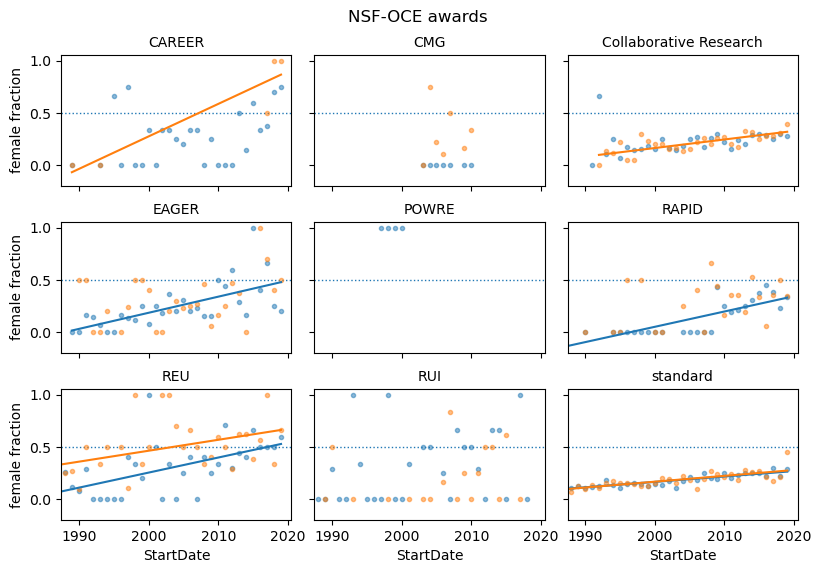

In [42]:
# female & male fraction of PIs
df = awards.groupby(['award_type',awards.StartDate.dt.year,'PI_gender'])['Abstract'].count().unstack()
pi_gender_by_atype = df.fillna(0).divide(df.sum(axis=1), axis=0)

# female & male fraction of co-PIs
copi_gender_by_atype = pd.DataFrame({'female': 
                   awards.groupby(['award_type',awards.StartDate.dt.year])['co-PI_female_frac'].mean()})
copi_gender_by_atype['male'] = 1 - copi_gender_by_atype.female

female_frac_by_atype = pd.DataFrame({'PI':pi_gender_by_atype['female'],
                                     'co-PI': copi_gender_by_atype['female']})

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(9.5, 6))
fig.subplots_adjust(hspace=0.275, wspace=0.1, top=0.9)
params = []
for ax, atype in zip(axs.ravel(), female_frac_by_atype.index.levels[0]):
    if atype == 'CMG':
        legend = True
    else:
        legend=False
    _ = female_frac_by_atype.loc[atype].plot(ax=ax, style=['C0.','C1.'], legend=False, alpha=alpha)
#     _ = female_frac_by_atype.loc[atype].rolling(nn,center=True).mean().plot(ax=ax, legend=legend)

    reg1, X = linreg(female_frac_by_atype.loc[atype].index, female_frac_by_atype.loc[atype].PI)
    if reg1.pvalues[1]<0.05:
        _ = ax.plot(female_frac_by_atype.loc[atype].index, reg1.predict(X), 'C0')
    y = female_frac_by_atype.loc[atype,'co-PI'].dropna()
    if y.size > 1:
        reg2, X = linreg(female_frac_by_atype.loc[atype].dropna().index, y)
        rs, sl, pv = reg2.rsquared,reg2.params[1],reg2.pvalues[1]
        if reg2.pvalues[1]<0.05:
            _ = ax.plot(female_frac_by_atype.loc[atype].dropna().index, reg2.predict(X), 'C1')
    else:
        rs, sl, pv = np.nan, np.nan, np.nan

    params.append([reg1.rsquared,reg1.params[1],reg1.pvalues[1],rs, sl, pv])

    _ = ax.set_title(atype, fontsize=10)
    x0, x1 = ax.get_xlim()
    _ = ax.hlines(0.5, x0, x1, linestyles='dotted', linewidth=1)
    _ = ax.set_xlim(x0,x1)    
for i in range(3):
    _ = axs[i,0].set_ylabel('female fraction')
_ = fig.text(0.5,0.95,'NSF-OCE awards', ha='center', va='bottom', fontsize=12)

lr_stats = pd.DataFrame(np.array(params), index=female_frac_by_atype.index.levels[0],
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.4f}', subset=['PI','co-PI'])

## Award size by gender

Statistics of the individual awards received by male and female PIs.

In [43]:
awards_male = awards[awards.PI_gender == 'male'][['StartDate','tot_amount_adjusted']]
awards_female = awards[awards.PI_gender == 'female'][['StartDate','tot_amount_adjusted']]

stats = pd.DataFrame({'male PIs': awards_male.tot_amount_adjusted.describe(),
                      'female PIs':awards_female.tot_amount_adjusted.describe()})
stats

,male PIs,female PIs
count,9.271000e+03,2.146000e+03
mean,1.186963e+06,1.047491e+06
std,1.221179e+07,1.539015e+07
min,0.000000e+00,0.000000e+00
25%,1.974344e+05,1.820283e+05
50%,4.218187e+05,4.111775e+05
75%,7.603440e+05,7.341902e+05
max,8.472425e+08,7.019176e+08


Box plot of the amount awarded to individual projects by male and female PIs.

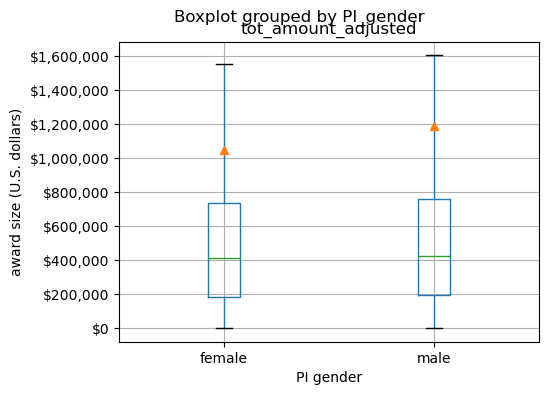

In [44]:
meanprops = dict(markeredgecolor='C1', markerfacecolor='C1')
fig, ax = plt.subplots()
_ = awards.boxplot('tot_amount_adjusted', by='PI_gender', showfliers=False, showmeans=True,
                   meanprops=meanprops, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(xlabel='PI gender', ylabel='award size (U.S. dollars)')
fig.subplots_adjust(left=0.2)

Box plot of the amount awarded to individual projects by male and female PIs in each year.

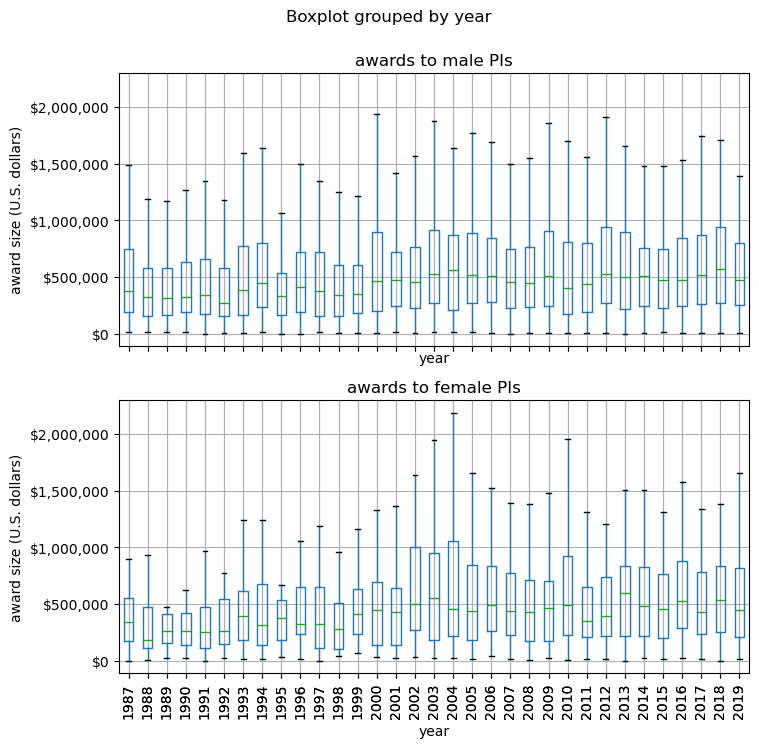

In [45]:
awards_male['year'] = awards_male.StartDate.dt.year
awards_female['year'] = awards_female.StartDate.dt.year
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(9,8))
_ = awards_male.boxplot('tot_amount_adjusted', by='year', showfliers=False, rot=90, ax=axs[0])
_ = awards_female.boxplot('tot_amount_adjusted', by='year', showfliers=False, rot=90, ax=axs[1])
axs[0].set_title('awards to male PIs')
axs[1].set_title('awards to female PIs')
for n in range(2):
    _ = axs[n].yaxis.set_major_formatter(fmt)
    _ = axs[n].set(ylabel='award size (U.S. dollars)')
fig.subplots_adjust(left=0.2)

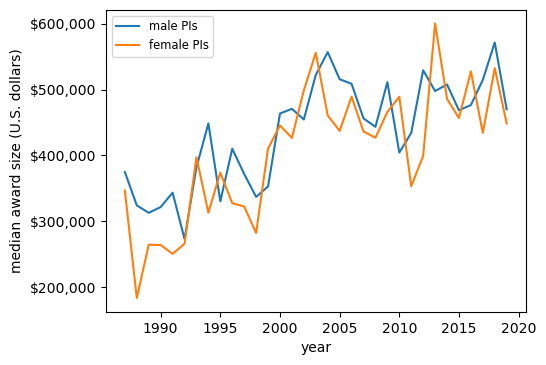

In [46]:
median_award = pd.DataFrame({'male PIs': awards_male.groupby('year')['tot_amount_adjusted'].median(),
                             'female PIs': awards_female.groupby('year')['tot_amount_adjusted'].median()})
fig, ax = plt.subplots()
_ = median_award.plot(ax=ax)
_ = ax.set(ylabel='median award size (U.S. dollars)')
_ = ax.yaxis.set_major_formatter(fmt)
fig.subplots_adjust(left=0.2)

t-test for equal means

In [47]:
import statsmodels.api as sm
male = awards_male.tot_amount_adjusted.values
female = awards_female.tot_amount_adjusted.values
tstat, pval, df = sm.stats.ttest_ind(male, female)
print('t={:.3f}, p={:.3f}, df={:.0f}'.format(tstat, pval, df))

t=0.452, p=0.651, df=11415
